In [109]:
import numpy as np
import pandas as pd
import random
import cv2
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import expand_dims
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Input, Lambda
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K

In [2]:
!pip install imutils
from imutils import paths

  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=1fd8fb0d744c3a1d229ef79abc93cee97d1c698e299a492522657e1e1f818844
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


### Todo

create subset of clients

- increase comm rounds 300
- increase hidden units 400
- increase no of layers
- no of clients 20

In [3]:
debug = 0

In [101]:
def load(paths, verbose=-1):
    '''expects images for each class in seperate dir, 
    e.g all digits in 0 class in the directory named 0 '''
    data = list()
    labels = list()
    # loop over the input images
    for (i, imgpath) in enumerate(paths):
        # load the image and extract the class labels        
        im_gray = cv2.imread(imgpath , cv2.IMREAD_GRAYSCALE)
        image = np.array(im_gray).flatten() # cv2.imread(imgpath) 
        # print(image.shape)
        label = imgpath.split(os.path.sep)[-2]
        # scale the image to [0, 1] and add to list
        data.append(image/255)
        labels.append(label)
        # show an update every `verbose` images
        if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
            print("[INFO] processed {}/{}".format(i + 1, len(paths)))
    # return a tuple of the data and labels
    
    return data, labels

def create_clients(image_list, label_list, num_clients=100, initial='clients'):
    ''' return: a dictionary with keys clients' names and value as 
                data shards - tuple of images and label lists.
        args: 
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1 
            
    '''

    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    #randomize the data
    data = list(zip(image_list, label_list))
    random.shuffle(data)  # <- IID
    
    # sort data for non-iid
#     max_y = np.argmax(label_list, axis=-1)
#     sorted_zip = sorted(zip(max_y, label_list, image_list), key=lambda x: x[0])
#     data = [(x,y) for _,y,x in sorted_zip]

    #shard data and place at each client
    size = len(data)//num_clients
    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

    #number of clients must equal number of shards
    assert(len(shards) == len(client_names))

    return {client_names[i] : shards[i] for i in range(len(client_names))} 


def batch_data(data_shard, bs=32, flip=False):
    '''Takes in a clients data shard and create a tfds object off it
    args:
        shard: a data, label constituting a client's data shard
        bs:batch size
    return:
        tfds object'''
    #seperate shard into data and labels lists
    data, label = zip(*data_shard)
    labels = list(label)
    
    if flip == True:
        random.shuffle(labels)
        
    dataset = tf.data.Dataset.from_tensor_slices((list(data), labels))
    return dataset.shuffle(len(label)).batch(bs)


def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    #get the bs
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #first calculate the total training data points across clinets
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    # get the total number of data points held by a client
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs
    
    
    if debug:
        print('global_count', global_count, 'local_count', local_count, 'bs', bs)
    
    return local_count/global_count


def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final



def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad


def test_model(X_test, Y_test,  model, comm_round):
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    #logits = model.predict(X_test, batch_size=100)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))
    return acc, loss


In [5]:
class SimpleMLP:
    @staticmethod
    def build(shape, classes):
        model = Sequential()
        model.add(Dense(200, input_shape=(shape,)))
        model.add(Activation("relu"))
        model.add(Dense(200))
        model.add(Activation("relu"))
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        return model
    
#     def build(shape, classes):
#         model = Sequential()
#         model.add(Input(shape=(shape[0], shape[1], shape[2])))
#         #model.add(Lambda(lambda x: expand_dims(x, axis=-1)))
#         model.add(Conv2D(filters=64, kernel_size=3, padding="same"))
#         model.add(Activation("relu"))
#         model.add(Conv2D(filters=64, kernel_size=3, padding="same"))
#         model.add(Activation("relu"))
#         model.add(MaxPooling2D())
#         model.add(Conv2D(filters=128, kernel_size=3, padding="same"))
#         model.add(Activation("relu"))
#         model.add(Conv2D(filters=128, kernel_size=3, padding="same"))
#         model.add(Activation("relu"))
#         model.add(MaxPooling2D())
#         model.add(Activation("relu"))
#         model.add(Conv2D(filters=256, kernel_size=3, padding="same"))
#         model.add(Activation("relu"))
#         model.add(Conv2D(filters=256, kernel_size=3, padding="same"))
#         model.add(Activation("relu"))
#         model.add(MaxPooling2D())
#         model.add(Activation("relu"))
#         model.add(Conv2D(filters=512, kernel_size=3, padding="same"))
#         model.add(Activation("relu"))
#         model.add(Conv2D(filters=512, kernel_size=3, padding="same"))
#         model.add(Activation("relu"))
#         model.add(MaxPooling2D())
#         model.add(Flatten())
#         model.add(Dense(32))
#         model.add(Dense(classes))
#         model.add(Activation("softmax"))
#         return model

In [6]:
#declear path to your mnist data folder
img_path = '../input/mnistasjpg/trainingSet/trainingSet' #'../input/cifar10-pngs-in-folders/cifar10/test'  # <-- test dataset #'../input/mnistasjpg/trainingSample/trainingSample' # <-- smaller dataset

#get the path list using the path object
image_paths = list(paths.list_images(img_path))

#apply our function
image_list, label_list = load(image_paths, verbose=10000)

#binarize the labels
lb = LabelBinarizer()
label_list = lb.fit_transform(label_list)

[INFO] processed 10000/42000
[INFO] processed 20000/42000
[INFO] processed 30000/42000
[INFO] processed 40000/42000


In [7]:
#split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(image_list, 
                                                    label_list, 
                                                    test_size=0.1, 
                                                    random_state=42)

### IID

In [8]:
len(X_train), len(X_test), len(y_train), len(y_test)

(37800, 4200, 37800, 4200)

In [9]:
#create clients
clients = create_clients(X_train, y_train, num_clients=100, initial='client')

In [10]:
# client_names = ['{}_{}'.format('client', i+1) for i in range(100)]
# s = clients['client_1'][0][1]*0
# for c in client_names:
#     sum = clients[c][0][1]
#     for i in range(1,378):
#         sum = sum + clients[c][i][1]
        
#     s = s + sum/378
# s

In [11]:
#process and batch the training data for each client
clients_batched = dict()
for (client_name, data) in clients.items():
    clients_batched[client_name] = batch_data(data)
    
#process and batch the test set  
test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))

In [12]:
lr = 0.01
comms_round = 300
loss='categorical_crossentropy'
metrics = ['accuracy']
optimizer = SGD(lr=lr, 
                decay=lr / comms_round, 
                momentum=0.9
               )          

In [13]:
#initialize global model

build_shape = 784 #(28, 28, 3)  # 1024 <- CIFAR-10    # 784 # for MNIST

smlp_global = SimpleMLP()
global_model = smlp_global.build(build_shape, 10) 
global_acc_list = []
global_loss_list = []

### Non-IID

In [14]:
def create_clients(image_list, label_list, num_clients=100, initial='clients'):
    ''' return: a dictionary with keys clients' names and value as 
                data shards - tuple of images and label lists.
        args: 
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1 
            
    '''

    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    #randomize the data
    # data = list(zip(image_list, label_list))
    # random.shuffle(data)  # <- IID
    
    # sort data for non-iid
    max_y = np.argmax(label_list, axis=-1)
    sorted_zip = sorted(zip(max_y, label_list, image_list), key=lambda x: x[0])
    data = [(x,y) for _,y,x in sorted_zip]

    #shard data and place at each client
    size = len(data)//num_clients
    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

    #number of clients must equal number of shards
    assert(len(shards) == len(client_names))

    return {client_names[i] : shards[i] for i in range(len(client_names))} 

In [15]:
len(X_train), len(X_test), len(y_train), len(y_test)

(37800, 4200, 37800, 4200)

In [102]:
#create clients
clients = create_clients(X_train, y_train, num_clients=100, initial='client')

In [150]:
PER_HUNDRED_BYZANTINE = 50

In [151]:
#process and batch the training data for each client
clients_batched = dict()
flipped = []
for (client_name, data) in clients.items():
    flip = True if random.randint(0,100) < PER_HUNDRED_BYZANTINE else False
    if flip:
        flipped.append(client_name)
    clients_batched[client_name] = batch_data(data, flip=flip)
    
print('flipped:', len(flipped))
    
#process and batch the test set  
test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))

flipped: 50


In [107]:
lr = 0.01 
comms_round = 300
loss='categorical_crossentropy'
metrics = ['accuracy']
optimizer = SGD(lr=lr, 
                decay=lr / comms_round, 
                momentum=0.9
               )          

In [108]:
#initialize global model

build_shape = 784 #(32, 32, 3)  # 1024 <- CIFAR-10    # 784 # for MNIST

smlp_global = SimpleMLP()
global_model = smlp_global.build(build_shape, 10) 
global_acc_list = []
global_loss_list = []

global_model.save_weights('model.h5')

def reset_model():
    global_model.load_weights('model.h5')

In [20]:
def fed_avg(weights):
    assert(len(weights) > 0)
    n_layers = len(weights[0])

    avg_weights = list()

    for layer in range(n_layers):
        layer_weights = np.array([w[layer] for w in weights])
        mean_layer_weights = np.mean(layer_weights, axis = 0)
        avg_weights.append(mean_layer_weights)

    return avg_weights


In [21]:
def score(weights, trainers):
    R = len(weights)
    f = R // 3 - 1
    closest_updates = R - f - 2

    scores = []

    for i in range(len(weights)):
      dists = []

      for j in range(len(weights)):
        if i == j:
          continue

        diff = np.subtract(weights[j],weights[i])
        l2_norm = np.sqrt(np.sum([np.sum(np.square(w)) for w in diff]))
        dists.append(l2_norm)

      dists_sorted = np.argsort(dists)[:closest_updates]
      score = np.array([dists[i] for i in dists_sorted]).sum()
      scores.append(score)
    return trainers, scores, weights

In [125]:
def local_score(weights, my_weights, other_trainers):
    R = len(weights)
    f = R // 3 - 1
    closest_updates = R - f - 2

    dists = []

    for i in range(len(weights)):
        diff = np.subtract(weights[i], my_weights)
        l2_norm = np.sqrt(np.sum([np.sum(np.square(w)) for w in diff]))
        dists.append(l2_norm)

    dists_sorted = np.argsort(dists)[:closest_updates]
    return [other_trainers[i] for i in dists_sorted]

In [56]:
# client/trainer cannot add itself to this list, as SC would reject it
def local_preference_calc(comm_round, historical_weight_dict, historical_preference_dict, my_trainer):
    if comm_round not in historical_weight_dict.keys():
        return
    
    prior_weight_dict =  historical_weight_dict[comm_round]
    trainers = list(prior_weight_dict.keys())
    weights = list(prior_weight_dict.values())
    my_index = trainers.index(my_trainer)
    my_weights = weights[my_index]
    trainers.pop(my_index)
    weights.pop(my_index)
    
    historical_preference_dict_round = historical_preference_dict[comm_round]
    preferred_trainer_list =  local_score(weights, my_weights, trainers)
    historical_preference_dict_round[my_trainer] = preferred_trainer_list
    
    

In [89]:
def trusted_clients(comm_round, historical_preference_dict, f = 3):
    count_dict = dict()
    round_pref_list = list(historical_preference_dict[comm_round].values())
    for pref in round_pref_list:
        for client in pref:
            if client not in count_dict:
                count_dict[client] = 1
            else:
                count_dict[client] += 1
    
    return dict(filter(lambda elem: elem[1] > f, count_dict.items()))

In [116]:
def trusted_weights_for_round(comm_round, historical_preference_dict, historical_weight_dict, byzantine_clients = [], f = 3):
    clients = trusted_clients(comm_round, historical_preference_dict, f)
    
    selected_byzantine = [x for x in clients if x in byzantine_clients]
    byzantine_cnt = len(selected_byzantine)
    
    if byzantine_cnt > 0:
        print('Uh oh, byzantines selected', byzantine_cnt)
    
    weight_dict = historical_weight_dict[comm_round]
    return [weight_dict[client] for client in clients]

In [22]:
def multikrum_aggregate(weights, trainers):
    assert(len(weights) == len(trainers))
    trainers, scores, weights = score(weights, trainers)

    medians = []

    for t, trainer in enumerate(trainers):
      medians.append(np.median(scores[t]))
    print('medians', medians)

    R = len(weights)
    f = R // 3 - 1

    sorted_idxs = np.argsort(medians)
    lowest_idxs = sorted_idxs[:R-f]
    selected_weights = [weights[i] for i in lowest_idxs]

    return fed_avg(selected_weights)

In [152]:
comms_round = 200
global_acc_list = []
global_loss_list = []
reset_model()    
historical_weight_dict = dict()
historical_preference_dict = dict()

#randomize client data - using keys
all_client_names = list(clients_batched.keys())

client_names = random.sample(all_client_names, k=20)
random.shuffle(client_names)

selected_byzantine = [x for x in client_names if x in flipped]
print('Byzantine cnt', len(selected_byzantine))

Byzantine cnt 13


In [153]:
#commence global training loop
for comm_round in range(comms_round):
    current_weight_dict = dict()
    historical_preference_dict[comm_round] = dict()
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()

    if debug: 
        # print('all_client_names', all_client_names)
        print('client_names', client_names)
    
    #loop through each client and create new local model
    for client in client_names:
        # first do the historical
        local_preference_calc(comm_round - 1, historical_weight_dict, historical_preference_dict, client)
        
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(build_shape, 10)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        local_model.fit(clients_batched[client], epochs=1, verbose=0)
        
        current_weight_dict[client] = local_model.get_weights()
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    historical_weight_dict[comm_round] = current_weight_dict    
    # always aggregate the prior round    
    agg_round = comm_round - 1
    if agg_round not in historical_weight_dict.keys():
        continue

        
#     local_weight_list = list(historical_weight_dict[agg_round].values())
    local_weight_list = trusted_weights_for_round(agg_round, historical_preference_dict, historical_weight_dict, selected_byzantine, 8)
    print('No of weights for aggregation', len(local_weight_list))
    average_weights = fed_avg(local_weight_list)
#     average_weights = multikrum_aggregate(unscaled_local_weight_list, client_names)
    
    #update global model 
    global_model.set_weights(average_weights)

    #test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
        global_acc_list.append(global_acc)
        global_loss_list.append(global_loss)
    
        

Uh oh, byzantines selected 13
No of weights for aggregation 13
comm_round: 1 | global_acc: 9.143% | global_loss: 2.3038010597229004
Uh oh, byzantines selected 13
No of weights for aggregation 13
comm_round: 2 | global_acc: 9.262% | global_loss: 2.3038461208343506
Uh oh, byzantines selected 13
No of weights for aggregation 13
comm_round: 3 | global_acc: 8.881% | global_loss: 2.304037570953369
Uh oh, byzantines selected 13
No of weights for aggregation 13
comm_round: 4 | global_acc: 8.952% | global_loss: 2.3040671348571777
Uh oh, byzantines selected 13
No of weights for aggregation 13
comm_round: 5 | global_acc: 8.500% | global_loss: 2.3042306900024414
Uh oh, byzantines selected 13
No of weights for aggregation 13
comm_round: 6 | global_acc: 8.667% | global_loss: 2.304192066192627
Uh oh, byzantines selected 13
No of weights for aggregation 13
comm_round: 7 | global_acc: 8.310% | global_loss: 2.3043861389160156
Uh oh, byzantines selected 13
No of weights for aggregation 13
comm_round: 8 |

Non-IID | total comm rounds 199


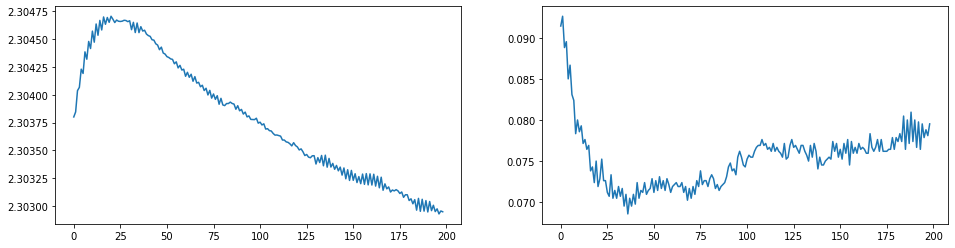

In [154]:
# Non-IID 
import matplotlib.pyplot as plt
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(list(range(0,len(global_loss_list))), global_loss_list)
plt.subplot(122)
plt.plot(list(range(0,len(global_acc_list))), global_acc_list)
print('Non-IID | total comm rounds', len(global_acc_list))           

In [131]:
noniid_df = pd.DataFrame(list(zip(global_acc_list, global_loss_list)), columns =['global_acc_list', 'global_loss_list'])
noniid_df.to_csv('CIFAR-10_Non-IID.csv',index=False)